# MultiClass Classification - First 500 bands

In this notebook I use the full spectral data available, and leveraging on `SMOTE` for upsample and `ICA` for dimensionality reduction, I run a `Fully Connected Sequential Neural Network` with a `Multilabel` architecture, trying to predict `Label`, a target resulting from the combination of `Crop` and `Stage`.

Interesting and useful links on ICA, that might be helpful if it's your first approach with the tecnique.

- Documentation Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

- Signal Separation:
https://en.wikipedia.org/wiki/Signal_separation

- ICA: https://en.wikipedia.org/wiki/Independent_component_analysis

- Sensitivity Analysis: https://en.wikipedia.org/wiki/Sensitivity_analysis

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#DataViz
import seaborn as sns

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from collections import Counter
from imblearn.over_sampling import SMOTE
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

#NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras import utils

#ICA
from sklearn.decomposition import FastICA

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

#MPL
from sklearn.neural_network import MLPClassifier

#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.options.display.max_columns = None

## Nulls

some bandwiths are nulls in all data because information about water absorption has been cleaned.

In [5]:
df = pd.read_csv('../data/GHISACONUS_2008_001_speclib_small_area.csv')

In [6]:
df.dropna(axis = 1, how = 'all', inplace= True)

In [7]:
df.isnull().sum().sum()

0

In [8]:
df.dropna(inplace= True)

## Preprocessing

In [9]:
features = [col for col in df.columns if col.startswith('X')]

In [10]:
df['Target'] = [','.join(i) for i in zip(df["Crop"],df["Stage"])]

In [11]:
df['XAEZ'] = to_categorical(df['XAEZ'], dtype='int32')

In [12]:
X = df[features]
Y = df['Target']

In [13]:
X.shape, Y.shape

((6988, 51), (6988,))

I have 24 possible combinations
- `corn` * 6 stages
- `cotton` * 6 stages
- `rice` * 2 stages  ---- removed rice for a test
- `soybean` * 6 stages
- `weat` * 4 stages

## Resampling by Crop AND Stage

### Encoding Y

In [14]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
Y = to_categorical(encoded_Y, dtype='int32')

### Train Test Split

In [17]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42, stratify=Y)

In [18]:
y_test.shape

(1049, 23)

## Independent Component Analysis

In [19]:
transformer = FastICA()

In [20]:
transformer_fitted = transformer.fit(X_train)

### Classes Distribution

In [21]:
oversample = SMOTE()

In [22]:
Y_combo = [target_class for row in get_combination_wise_output_matrix(y_train, order=1) for target_class in row]
classes_combo = {i:Y_combo.count(i) for i in Y_combo}

In [23]:
# summarize distribution
for k,v in classes_combo.items():
    per = v / len(y_test) * 100
    print(f'Class={k}, n={v} ({round(per, 2)}%)')

Class=(14,), n=494 (47.09%)
Class=(22,), n=403 (38.42%)
Class=(20,), n=646 (61.58%)
Class=(13,), n=693 (66.06%)
Class=(16,), n=71 (6.77%)
Class=(0,), n=717 (68.35%)
Class=(4,), n=592 (56.43%)
Class=(1,), n=225 (21.45%)
Class=(7,), n=269 (25.64%)
Class=(6,), n=167 (15.92%)
Class=(17,), n=247 (23.55%)
Class=(18,), n=156 (14.87%)
Class=(19,), n=60 (5.72%)
Class=(5,), n=424 (40.42%)
Class=(11,), n=55 (5.24%)
Class=(3,), n=109 (10.39%)
Class=(2,), n=161 (15.35%)
Class=(15,), n=112 (10.68%)
Class=(8,), n=183 (17.45%)
Class=(10,), n=69 (6.58%)
Class=(12,), n=43 (4.1%)
Class=(21,), n=31 (2.96%)
Class=(9,), n=12 (1.14%)


In [24]:
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [25]:
Y_combo_smote = [target_class for row in get_combination_wise_output_matrix(y_train, order=1) for target_class in row]
smote_classes_combo = {i:Y_combo_smote.count(i) for i in Y_combo_smote}

In [26]:
# summarize distribution
for k,v in smote_classes_combo.items():
    per = v / len(Y) * 100
    print(f'Class={k}, n={v} ({round(per, 2)}%)')

Class=(14,), n=717 (10.26%)
Class=(22,), n=717 (10.26%)
Class=(20,), n=717 (10.26%)
Class=(13,), n=717 (10.26%)
Class=(16,), n=717 (10.26%)
Class=(0,), n=717 (10.26%)
Class=(4,), n=717 (10.26%)
Class=(1,), n=717 (10.26%)
Class=(7,), n=717 (10.26%)
Class=(6,), n=717 (10.26%)
Class=(17,), n=717 (10.26%)
Class=(18,), n=717 (10.26%)
Class=(19,), n=717 (10.26%)
Class=(5,), n=717 (10.26%)
Class=(11,), n=717 (10.26%)
Class=(3,), n=717 (10.26%)
Class=(2,), n=717 (10.26%)
Class=(15,), n=717 (10.26%)
Class=(8,), n=717 (10.26%)
Class=(10,), n=717 (10.26%)
Class=(12,), n=717 (10.26%)
Class=(21,), n=717 (10.26%)
Class=(9,), n=717 (10.26%)


### Transform ICA

Upsample and ICA of data for combination of crop and stage

In [27]:
X_test = transformer.transform(X_test)
X_train = transformer.transform(X_train)

## Neural Network

In [28]:
input_dim = X_train.shape[1]

In [58]:
model = Sequential()

    #layer 1
model.add(Dense(128,
                   activation = 'relu',
                   input_dim = input_dim,
               kernel_regularizer = l2(.001)
               ))
    #layer 2
model.add(Dropout(.25))

    #layer 2
model.add(Dense(256, activation = 'relu'))

    #layer 3
model.add(Dropout(.5))

    #layer 3
model.add(Dense(256, activation = 'relu'))

    #layer 3
model.add(Dense(256, activation = 'relu', kernel_regularizer = l2(.0001)))

    #layer 3
model.add(Dense(128, activation = 'relu'))

    #layer 3
model.add(Dense(128, activation = 'relu'))

    #output layer
model.add(Dense(23, activation = 'sigmoid'))

    #Compile model
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 1_500, batch_size = 256, verbose = 0)

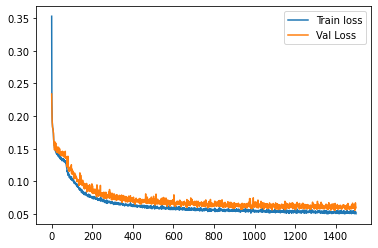

In [59]:
#plot the loss 
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

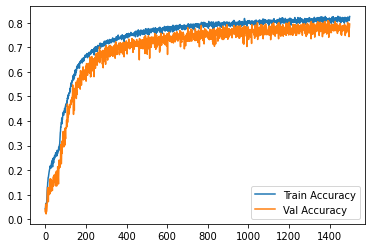

In [60]:
#pyplot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend();

#### Model Scoring

In [61]:
predictions = np.argmax(model.predict(X_test), axis=-1)
prediction = np.argmax(to_categorical(predictions), axis = 1)
prediction = encoder.inverse_transform(prediction)

In [62]:
y_trues = np.argmax(y_test, axis=-1)
y_true = np.argmax(to_categorical(y_trues), axis = 1)
y_true = encoder.inverse_transform(y_true)

In [63]:
from sklearn.metrics import accuracy_score

In [64]:
print(f'The Balanced Accuracy score is: {(round(balanced_accuracy_score(y_true, prediction), 3)*100)}%')
print(f'The Accuracy score is: {(round(accuracy_score(y_true, prediction), 3)*100)}%')

The Balanced Accuracy score is: 79.10000000000001%
The Accuracy score is: 79.5%


In [65]:
labels = ['corn,Critical',
          'corn,Early_Mid',
          'corn,Emerge_VEarly',
          'corn,Harvest',
          'corn,Late',
          'corn,Mature_Senesc',
          'cotton,Critical',
          'cotton,Early_Mid',
          'cotton,Emerge_VEarly',
          'cotton,Harvest',
          'cotton,Mature_Senesc',
          'rice,Early_Mid',
          'rice,Late',
          'soybean,Critical',
          'soybean,Early_Mid',
          'soybean,Emerge_VEarly',
          'soybean,Harvest',
          'soybean,Late',
          'soybean,Mature_Senesc',
          'winter_wheat,Critical',
          'winter_wheat,Emerge_VEarly',
          'winter_wheat,Late',
         'winter_wheat,Mature_Senesc']

In [66]:
labels_dic = {1: 'corn,Critical',
          2: 'corn,Early_Mid',
          3: 'corn,Emerge_VEarly',
          4: 'corn,Harvest',
          5: 'corn,Late',
          6: 'corn,Mature_Senesc',
          7: 'cotton,Critical',
          8: 'cotton,Early_Mid',
          9: 'cotton,Emerge_VEarly',
          10: 'cotton,Harvest',
          11: 'cotton,Mature_Senesc',
          12: 'rice,Early_Mid',
          13: 'rice,Late',
          14: 'soybean,Critical',
          15: 'soybean,Early_Mid',
          16: 'soybean,Emerge_VEarly',
          17: 'soybean,Harvest',
          18: 'soybean,Late',
          19: 'soybean,Mature_Senesc',
          20: 'winter_wheat,Critical',
          21: 'winter_wheat,Emerge_VEarly',
          22: 'winter_wheat,Late',
         23: 'winter_wheat,Mature_Senesc',
            24: 'cotton,Late'}

In [67]:
from sklearn.metrics import balanced_accuracy_score, classification_report

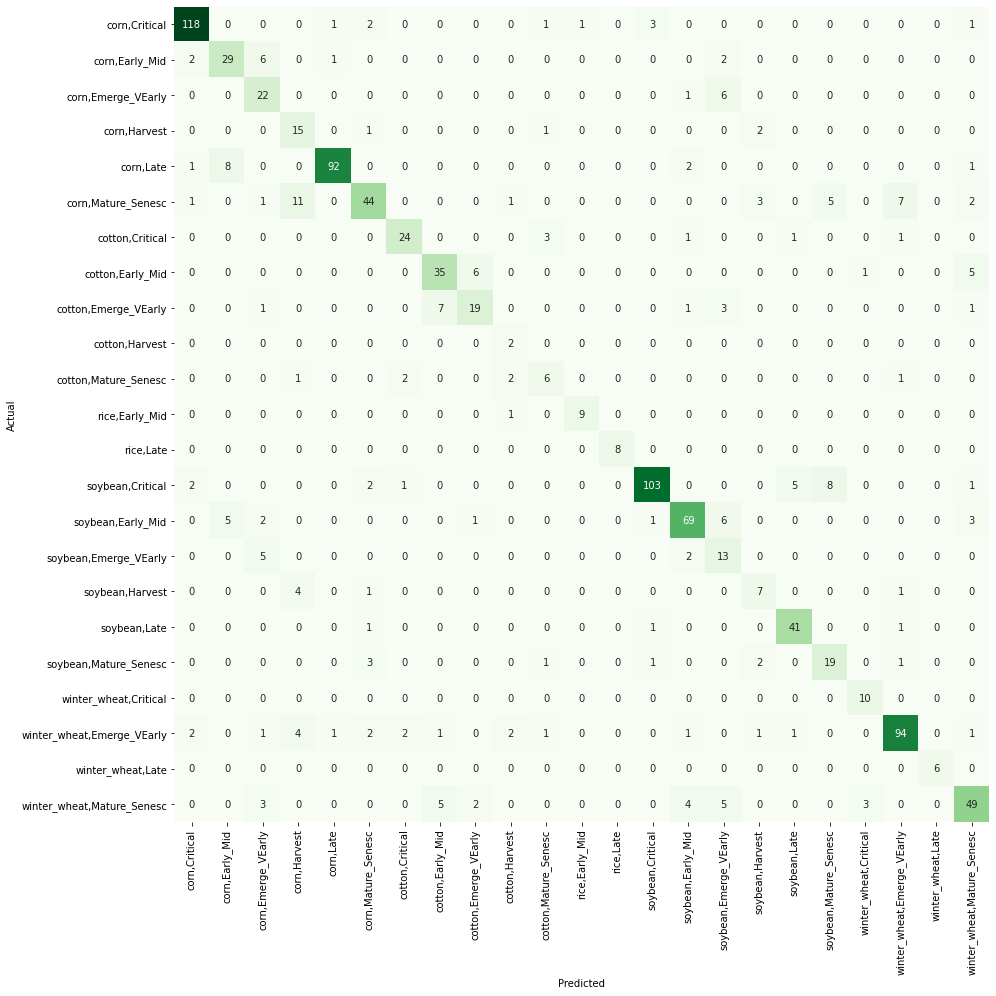

In [68]:
conf_mat = confusion_matrix(y_true, prediction)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap= 'Greens', vmin = 0,
            xticklabels=labels, yticklabels=labels, square=True, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Wrong predictions analysis

Above I have `94` total wrong predictions. I want to collect them and analyze the results.

In particular, I want to find out if they are misslabeled only for `crop`, `stage` or for both.

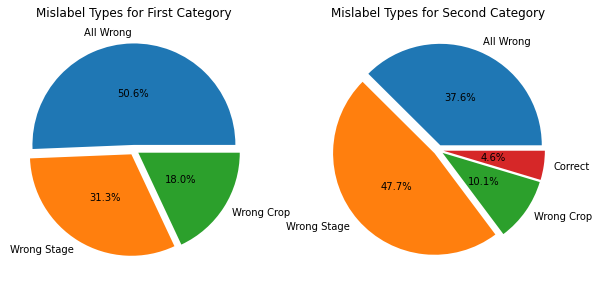

In [69]:
y_pred = model.predict(X_test)
wrong_index = []
dict_wrong = {'index':[],
        'pred':[], 
        'true':[] } 
dict_true = {'index':[],
        'pred':[], 
        'true':[] } 

wrong = pd.DataFrame(dict_wrong)
correct = pd.DataFrame(dict_true)
for i, (a, b) in enumerate(zip (prediction, y_true)):
    if a != b:
        new_row = {'index':i,'pred':a, 'true':b}
        wrong = wrong.append(new_row, ignore_index=True)
    if a == b:
        new_row = {'index':i,'true':b}
        correct = correct.append(new_row, ignore_index=True)

wrong['index'] = wrong['index'].astype(int)
correct['index'] = correct['index'].astype(int)

wrong_matrix_list = []
mislabel_true_list = []
for i in wrong['index']:
    wrong_matrix_list.append(y_pred[i])
    mislabel_true_list.append(y_true[i])

correct_matrix_list = []
for i in correct['index']:
    correct_matrix_list.append(y_pred[i])
    
#get two most likely classes RIGHT
cg = []
d = {'first':[],
     'c_first':[],
     'second':[],
     'c_sec':[]}
cg = pd.DataFrame(d) #bg stands for correct guess

for el in correct_matrix_list:
    i_m1, i_m2  = 0, 0
    m1, m2 = 0, 0
    for i, x in enumerate(el):
        if x >= m1:
            m1, m2 = x, m1
            i_m1  = i
        elif x > m2:
            m2 = x
            i_m2  = i
    new_row = {'c_first':i_m1,'first':m1, 'c_sec':i_m2, 'second':m2}
    cg = cg.append(new_row, ignore_index=True)    

#get two most likely classes WRONG
bg = []
d = {'first':[],
     'c_first':[],
     'second':[],
     'c_sec':[],
    'c_true':[]}
bg = pd.DataFrame(d) #bg stands for best guess

for el in wrong_matrix_list:
    i_m1, i_m2  = 0, 0
    m1, m2 = 0, 0
    for i, x in enumerate(el):
        if x >= m1:
            m1, m2 = x, m1
            i_m1  = i
        elif x > m2:
            m2 = x
            i_m2  = i
    new_row = {'c_first':i_m1,'first':m1, 'c_sec':i_m2, 'second':m2}
    bg = bg.append(new_row, ignore_index=True)
    bg['c_true'] = np.resize(mislabel_true_list, len(bg))
    
    
#transform classes into labels
bg['c_first'] = bg['c_first'].map(labels_dic)
bg['c_sec'] = bg['c_sec'].map(labels_dic)
cg['c_first'] = cg['c_first'].map(labels_dic)
cg['c_sec'] = cg['c_sec'].map(labels_dic)
bg = bg.fillna('cotton,Late') #24th class was dropped and needs to be hard encoded
cg = cg.fillna('cotton,Late') #24th class was dropped and needs to be hard encoded

#split crop and stage
bg['crop_1'], bg['stage_1'] = bg['c_first'].str.split(',', 1).str
bg['crop_2'], bg['stage_2'] = bg['c_sec'].str.split(',', 1).str
bg['crop_true'], bg['stage_true'] = bg['c_true'].str.split(',', 1).str

cg['crop_1'], cg['stage_1'] = cg['c_first'].str.split(',', 1).str
cg['crop_2'], cg['stage_2'] = cg['c_sec'].str.split(',', 1).str

#create new columns describing type of mislabeling in binary
#FIRST LABEL
bg['all_wrong'] = np.where((bg['crop_1'] != bg['crop_true']) & (bg['stage_1'] != bg['stage_true']) , "1", 
                                   np.where((bg['crop_1'] == bg['crop_true']) | (bg['stage_1'] == bg['stage_true']), '0', 'XX'))

bg['wrong_stage'] = np.where((bg['crop_1'] == bg['crop_true']), "1", 
                                   np.where((bg['crop_1'] != bg['crop_true']), '0', 'XX'))

bg['wrong_crop'] = np.where((bg['stage_1'] == bg['stage_true']) , "1", 
                                   np.where((bg['stage_1'] != bg['stage_true']), '0', 'XX'))

#SECOND LABEL
bg['all_wrong_2'] = np.where((bg['crop_2'] != bg['crop_true']) & (bg['stage_2'] != bg['stage_true']) , "1", 
                                   np.where((bg['crop_2'] == bg['crop_true']) | (bg['stage_2'] == bg['stage_true']), '0', 'XX'))

bg['wrong_stage_2'] = np.where((bg['crop_2'] == bg['crop_true']), "1", 
                                   np.where((bg['crop_2'] != bg['crop_true']), '0', 'XX'))

bg['wrong_crop_2'] = np.where((bg['stage_2'] == bg['stage_true']) , "1", 
                                   np.where((bg['stage_2'] != bg['stage_true']), '0', 'XX'))


bg['all_correct_2'] = np.where((bg['crop_2'] != bg['crop_true']) | (bg['stage_2'] != bg['stage_true']) , "0", 
                                   np.where((bg['crop_2'] == bg['crop_true']) & (bg['stage_2'] == bg['stage_true']), '1', 'XX'))



#error label column
bg['error_label'] = np.where((bg['wrong_crop'] == '1') , "Wrong Crop", 
                                    np.where((bg['wrong_stage'] == '1'), 'Wrong Stage', 'All Wrong'))

#CORRECT
#create new columns describing type of mislabeling in binary
#FIRST LABEL
cg['sec_both_wrong'] = np.where((cg['crop_1'] != cg['crop_2']) & (cg['stage_1'] != cg['stage_2']) , "1", 
                                   np.where((cg['crop_1'] == cg['crop_2']) | (cg['stage_1'] == cg['stage_2']), '0', 'XX'))

cg['sec_wrong_stage'] = np.where((cg['stage_1'] == cg['stage_2'] ), "0", 
                                   np.where((cg['stage_1'] != cg['stage_2']), '1', 'XX'))

cg['sec_wrong_crop'] = np.where((cg['crop_1'] != cg['crop_2']) , "1", 
                                   np.where((cg['crop_1'] == cg['crop_2']), '0', 'XX'))

#error label column
cg['error_label'] = np.where((cg['sec_wrong_crop'] == '1') , "Wrong Crop", 
                                    np.where((cg['sec_wrong_stage'] == '1'), 'Wrong Stage', 'All Wrong'))



#store values for plots
wrong_dist = [bg["all_wrong"].astype(int).sum(),
              bg["wrong_stage"].astype(int).sum(),
              bg["wrong_crop"].astype(int).sum()]
wrong_dist_2 = [bg["all_wrong_2"].astype(int).sum(),
              bg["wrong_stage_2"].astype(int).sum(),
              bg["wrong_crop_2"].astype(int).sum(),
             bg["all_correct_2"].astype(int).sum()]

lab_wrong_dist = ['All Wrong', 'Wrong Stage', 'Wrong Crop']
lab_wrong_dist_2 = ['All Wrong', 'Wrong Stage', 'Wrong Crop', 'Correct']


#plot pie chart
pie, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,6])
ax1.set_title('Mislabel Types for First Category')
ax1.pie(x=wrong_dist, autopct="%.1f%%", explode=[0.05]*3, labels=lab_wrong_dist, pctdistance=0.5)
ax2.set_title('Mislabel Types for Second Category')
ax2.pie(x=wrong_dist_2, autopct="%.1f%%", explode=[0.05]*4, labels=lab_wrong_dist_2, pctdistance=0.5);

We can notice from the pie charts above that the mdel predicts correctly either the crop or the stage in 50% of the wrong predictions. Also, looking into the `second best values` we notice that only `4.6%` consist in the correct prediction, but `43.9%` of cases correctly identify the crop and miss to identify the Stage.

#### Visualize wrong predictions spectrum

In [70]:
freq = df.columns.drop(['UniqueID', 'Crop', 'Stage', 'Target'])
df_standard = pd.DataFrame(df.groupby(['Target'])[freq].mean())

In [71]:
df_standard = df_standard.loc[['corn,Emerge_VEarly', 'corn,Early_Mid', 'corn,Critical',  'corn,Mature_Senesc', 'corn,Harvest', 'corn,Late',
                    'cotton,Emerge_VEarly', 'cotton,Early_Mid', 'cotton,Critical',  'cotton,Mature_Senesc', 'cotton,Harvest',
                    'soybean,Emerge_VEarly', 'soybean,Early_Mid', 'soybean,Critical',  'soybean,Mature_Senesc', 'soybean,Harvest', 'soybean,Late',
                    'winter_wheat,Emerge_VEarly', 'winter_wheat,Critical',  'winter_wheat,Mature_Senesc', 'winter_wheat,Late',
                    'rice,Early_Mid', 'rice,Late'], :]
df_standard.reset_index(inplace=True)

In the plots below we see the wrong predictions (colored lines) plotted against the average of their correct class.

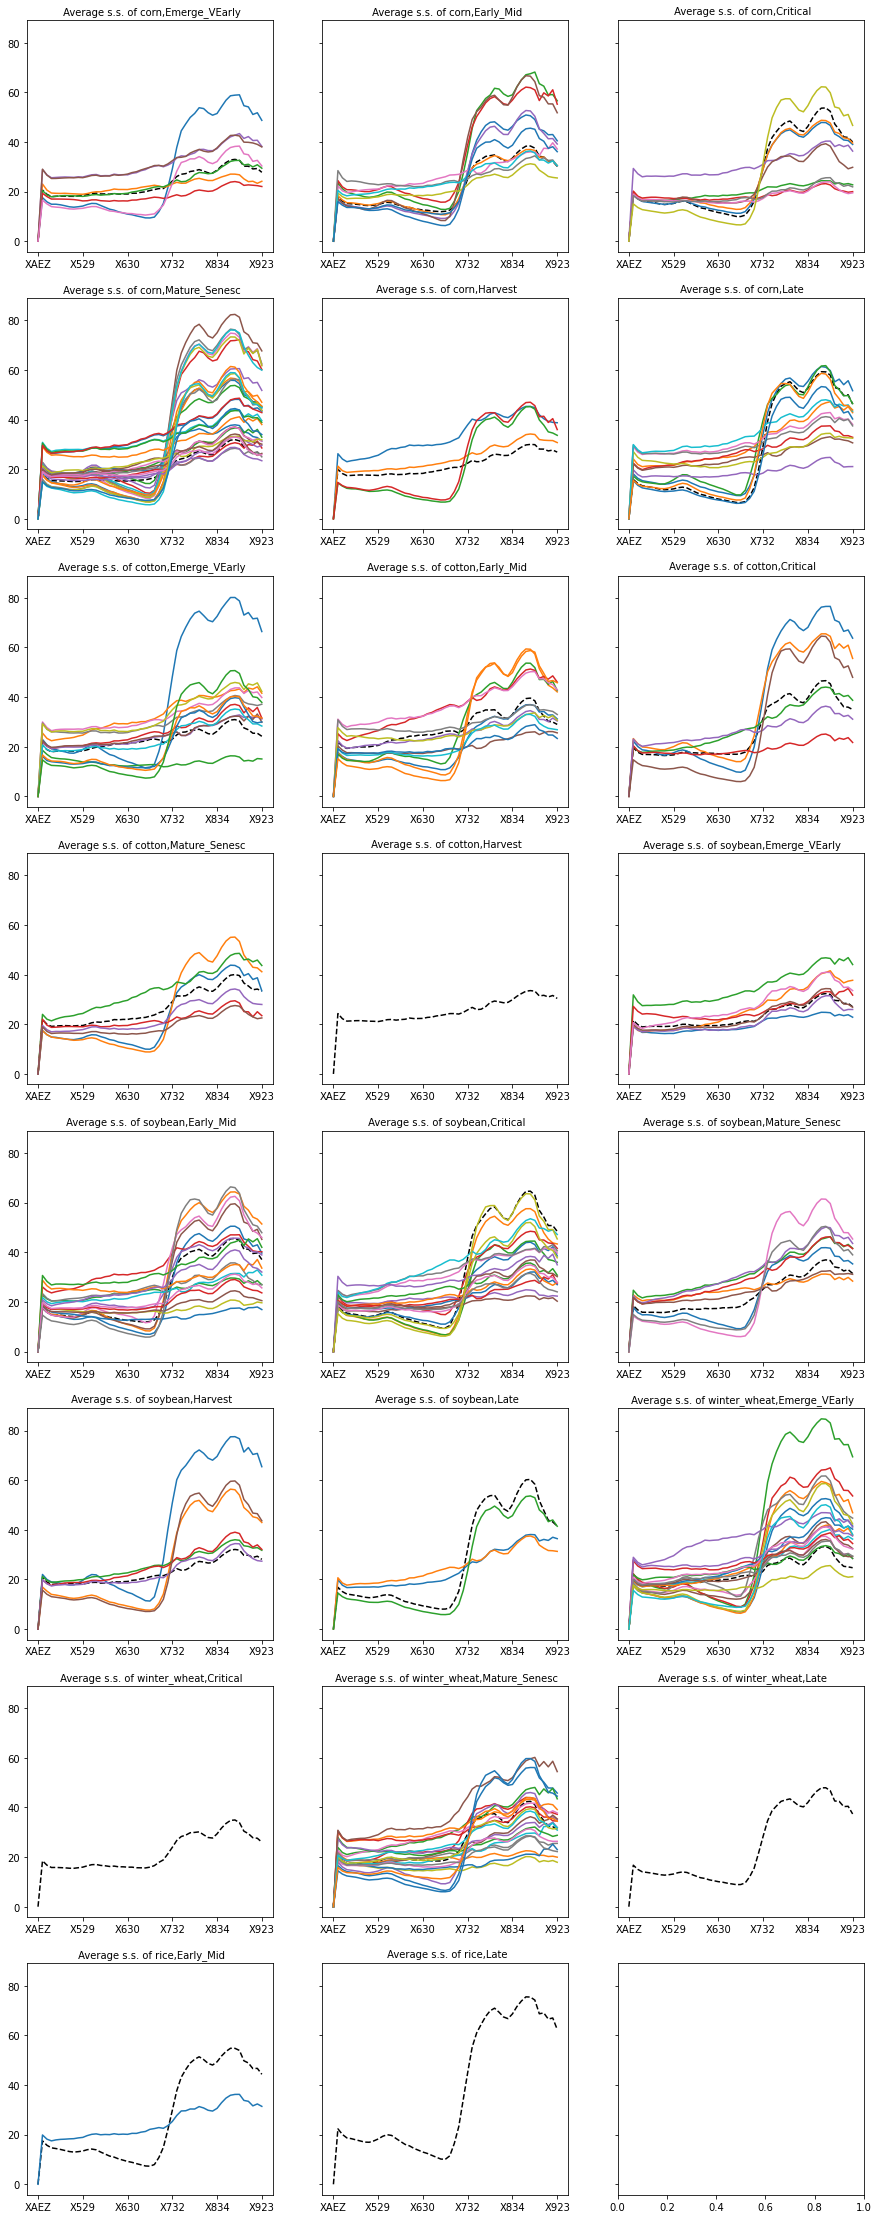

In [73]:
fig, grid_x = plt.subplots(nrows=8, ncols=3, figsize=(15,5*8), sharey=True) 
grid_x = grid_x.flatten() 

for i in range(0, len(df_standard)):
    grid_x[i].set_title(f' Average s.s. of {df_standard.Target[i]}', fontsize =10)
    df_standard.iloc[i].filter(like='X', axis=0).plot(kind='line', ax = grid_x[i], c= 'black', style= '--')
    
    lab = str(df_standard.Target[i])
    
    for j, w in enumerate(wrong['true']):
        if w == lab:
            df.iloc[j].filter(like='X', axis=0).plot(kind='line', ax = grid_x[i])

Two consideration on this plot:

- the average could be misleading, as some spectra can wrongly appear like outliers.Especially for the most densly populated graphs, the representativity of the average might not b significant.

- although, for the fewer populated graphs, such as `Soybean, Late` and `Rice, Early_Mid`, it might be a case of mislabeling. In fact, by using the Julian Days and not actual local ground truth data, it might be that these specific crops were wrongfully assigned to a vegetative stage that they were not currently at. Also for `Soy, Critical` the model seems to wrongfully predict below-average-looking spectra.

The graph below represents all averages by class for reference.

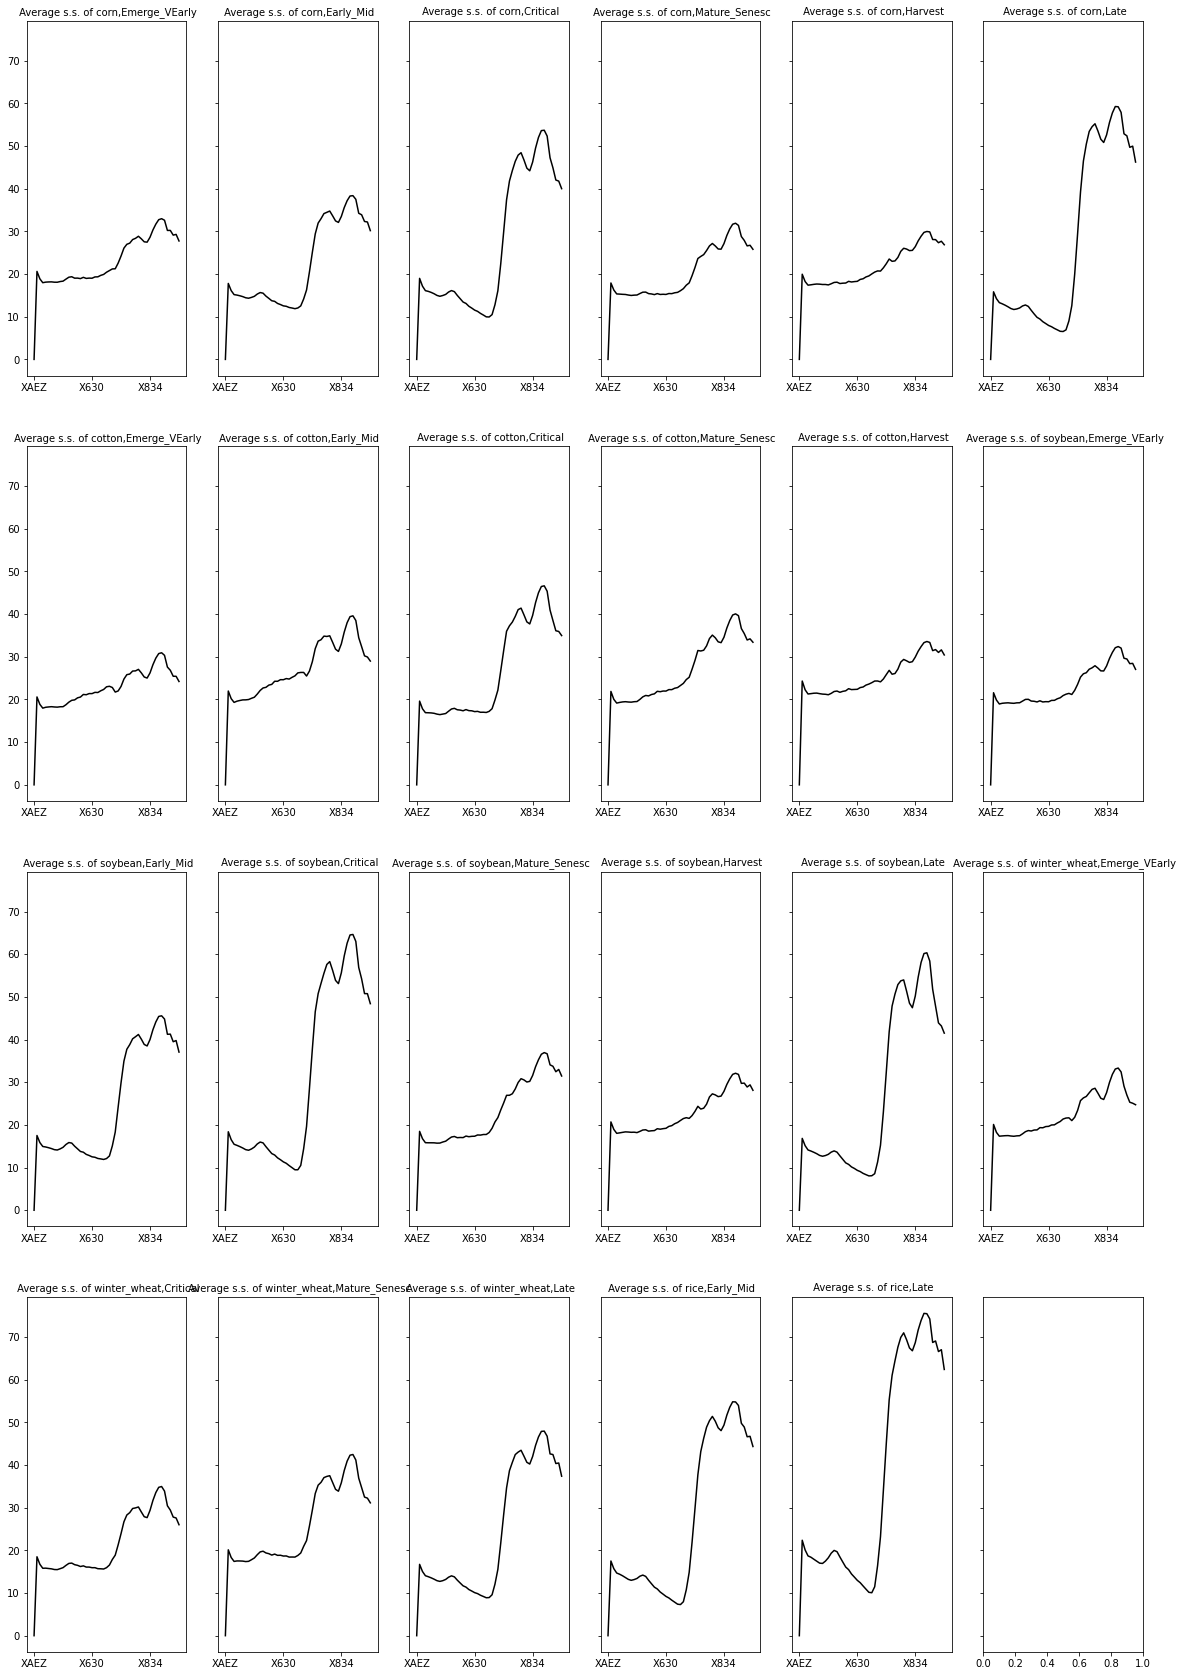

In [259]:
fig, grid_x = plt.subplots(nrows=4, ncols=6, figsize=(20,5*6), sharey='all') 
grid_x = grid_x.flatten() 

for i in range(0, len(df_standard)):
    df_standard.iloc[i].filter(like='X', axis=0).plot(kind='line', ax = grid_x[i], c= 'black')
    grid_x[i].set_title(f' Average s.s. of {df_standard.Target[i]}', fontsize =10)

The graphs below show the confidence level of the pomel for right and wrong predictions for their first and second guess. I wanted to see if to a wrong prediction was associated a lower confidence.

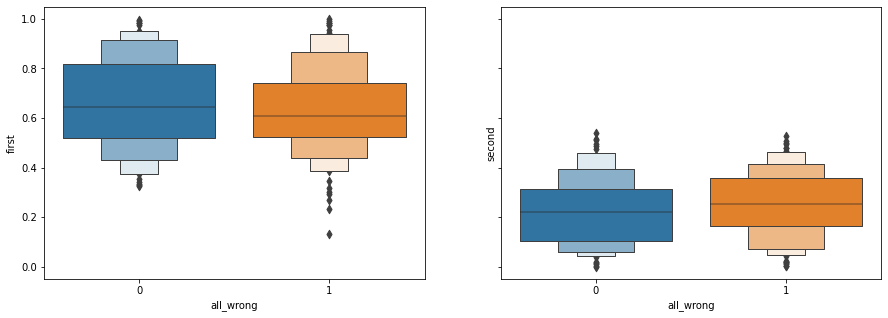

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
sns.boxenplot(ax=ax[0], data = bg, x= 'all_wrong', y= 'first')
sns.boxenplot(ax=ax[1], data = bg, x= 'all_wrong', y= 'second');

[Right] First I plot the predictions that are entirely wrong (`1`, in yellow) vs partially wrong predictions (`0`, in blue) and the confidence of the model seem to be slidly lower.

[Left] For the second class the wrong model has on average slightly higher confidence.

This seems to confirm that the model is recognizing a lover confidence in completely wrong predictions vs partially wrong predictions, even if not on a high extent.

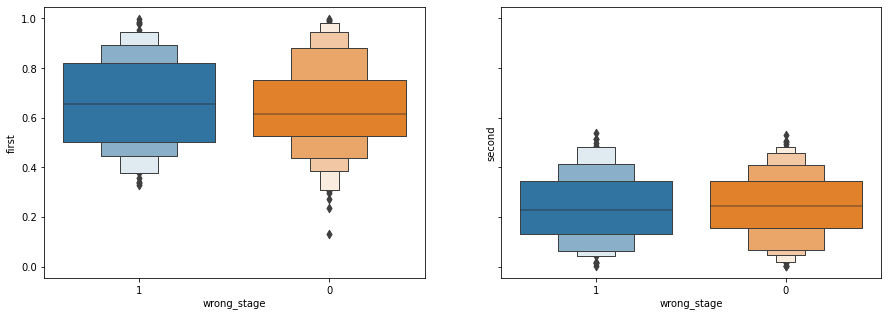

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
sns.boxenplot(ax=ax[0], data = bg, x= 'wrong_stage', y= 'first')
sns.boxenplot(ax=ax[1], data = bg, x= 'wrong_stage', y= 'second');

For wrongful `Stage` prediction (`1`, blue color), the confidence seems higher than the rest of the wrong predictions. This is consistent with the piechart above, showing a more consistent portion of `Stage` misslabeling vs `Crop` one.

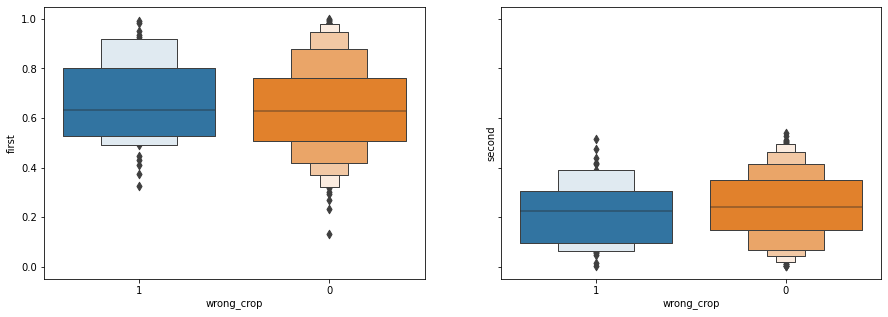

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
sns.boxenplot(ax=ax[0], data = bg, x= 'wrong_crop', y= 'first')
sns.boxenplot(ax=ax[1], data = bg, x= 'wrong_crop', y= 'second');

In regards to predictions misslabeling only `Crop`, is significant to notice that the confidence in second class is significantly lower. This reinforces the believe that the model predicts better the crop type than the stage. 

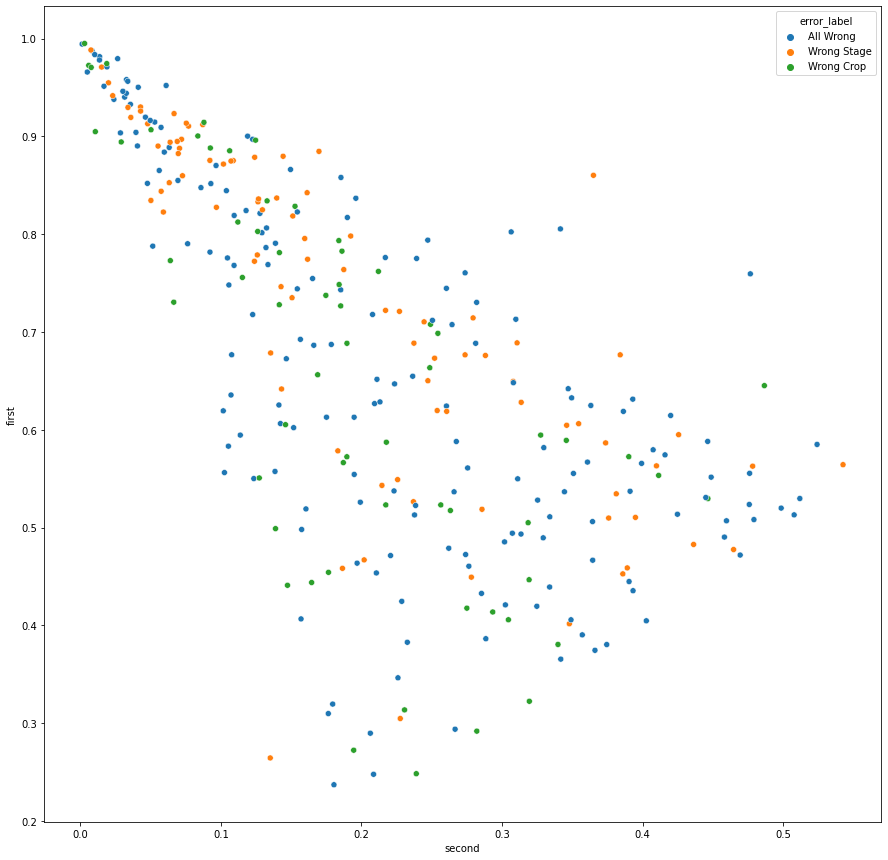

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=bg, x = 'second', y = 'first', hue='error_label', hue_order=lab_wrong_dist);

To check for linearity of confidence between misslabeling types I plot probability of the first guess ws the second.

We can notice that on average the least confident the model is with the first guess, the more it is on its second. There ar never two classes competing at very close confidence level.

Although it can be seen that there are a handful of outliers in the lower mid of the plot that have significant low confidence in both first and second predicted class.

## MLP Classification

From ***Parallel Classification of Hyperspectral Images Using Neural Network*** - p. 193 *Computational Intelligence for Remote Sensing*

In [88]:
#Initializing the MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(128,256,256,256),
                    max_iter=1000,
                    activation = 'relu',
                    solver='adam',
                    learning_rate= 'adaptive',
                    random_state=1)

clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(128, 256, 256, 256), learning_rate='adaptive',
              max_iter=1000, random_state=1)

In [89]:
clf.score(X_test, y_test)

0.7225929456625357

In [90]:
predictions = np.argmax(clf.predict(X_test), axis=-1)
prediction = np.argmax(to_categorical(predictions), axis = 1)
prediction = encoder.inverse_transform(prediction)

### Model Score

In [91]:
print(f'The Balanced Accuracy score is: {(round(balanced_accuracy_score(y_true, prediction), 2)*100)}%')

The Balanced Accuracy score is: 70.0%


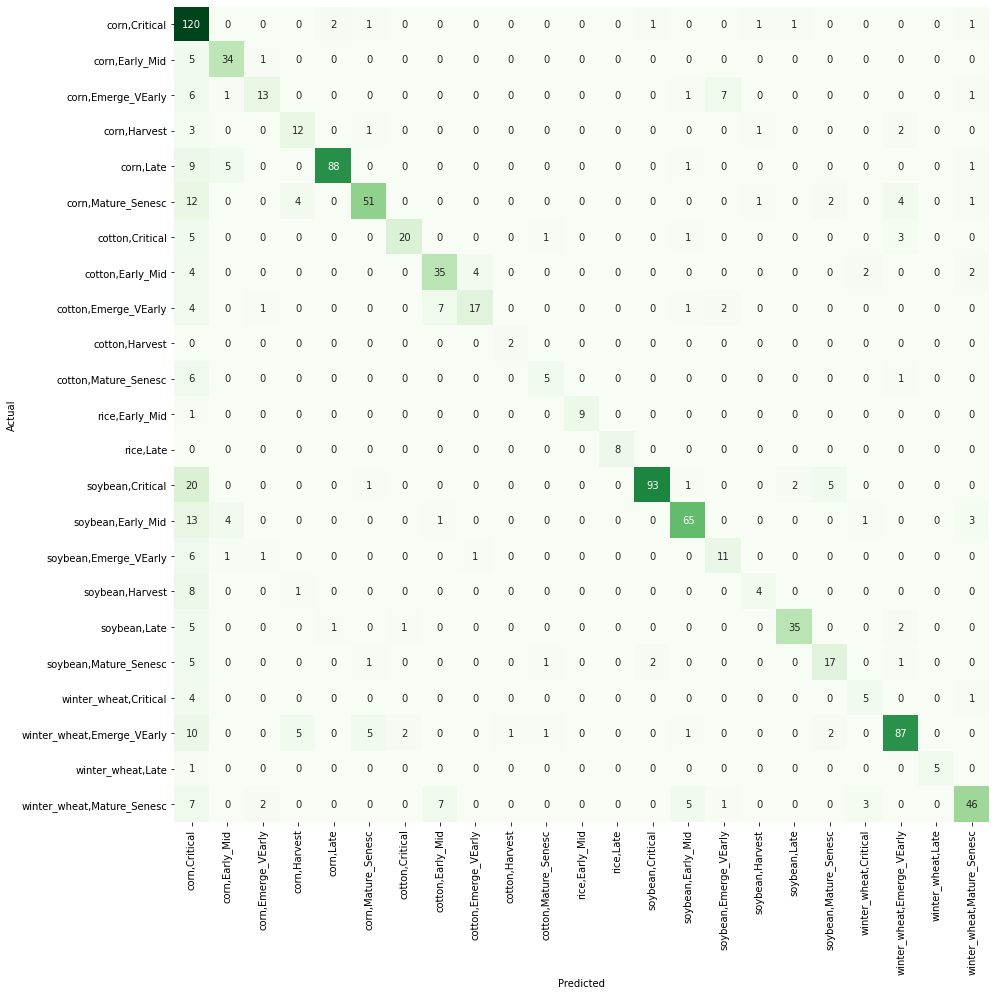

In [92]:
conf_mat = confusion_matrix(y_true, prediction)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap= 'Greens',
            xticklabels=labels, yticklabels=labels, square=True, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

MLP significantly overprecits the first class in this case. Fo r this reason I decide not to plot the wrong predictions for this model, as it probably requires more tuning rather than showing trends in the dataset.